Back to the main [Index](../index.ipynb)

# Post-processing tools for electron band energies

In the next sections we show how to plot electron band structures and density of states (DOSes) using the `netcdf` files produced by `ABINIT`. 
For the tutorial, we will use the `netcdf` files shipped with `abipy`. 
The function `abidata.ref_file` returns the absolute path of the reference `abipy` file. In your scripts, you have to replace `data.ref_file("abipy_filename")` with a string specifying the location of your `netcdf` file.

Remember that it's possible to generate automatically a jupyter notebook within the shell with the shell command: `abiopen.py GSRFILE -nb`

In [1]:
# Use this at the beginning of your script so that your code will be compatible with python3
from __future__ import division, print_function, unicode_literals

from abipy import abilab
from abipy.abilab import abiopen
# Import abipy reference data.
import abipy.data as abidata

# This line configures matplotlib to show figures embedded in the notebook, 
# instead of poping up a new window. 
%matplotlib notebook

## The GSR File

The `GSR` file (mnemonics: Ground-State Results) is a netcdf file with the 
results produced by SCF or NSCF ground-state calculations 
(band energies, forces, energies, stress tensor).
The `GSR` has a `Structure` and a `ElectronBands` object.
The `Structure` defines the crystalline geometry while `ElectronBands` contains 
the band energies, the occupation factors, the list of k-points.

To open a `GSR` file, simply use the `abiopen` function defined in `abipy.abilab`:

In [2]:
with abiopen(abidata.ref_file("si_nscf_GSR.nc")) as gsr:
    print(gsr.structure, 2*"\n")
    print("pressure:", gsr.pressure)

/Users/gmatteo/git_repos/pymatgen/pymatgen/symmetry/bandstructure.py:61: UserWarning: The input structure does not match the expected standard primitive! The path can be incorrect. Use at your own risk.
  warnings.warn("The input structure does not match the expected standard primitive! "


Full Formula (Si2)
Reduced Formula: Si
abc   :   3.866975   3.866975   3.866975
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c
---  ----  ----  ----  ----
  0  Si    0     0     0
  1  Si    0.25  0.25  0.25 


pressure: -2.94210329997e+104 GPa


<div class="alert">
In python we start to count from zero, thus the first band has index 0 and the first spin is 0
AbiPy uses the same convention so be very careful when specifying band, spin or k-point indices. 
</div>

A GSR file has an `ElectronBands` object:

In [3]:
print(gsr.ebands)

Full Formula (Si2)
Reduced Formula: Si
abc   :   3.866975   3.866975   3.866975
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c
---  ----  ----  ----  ----
  0  Si    0     0     0
  1  Si    0.25  0.25  0.25

Number of electrons: 8.0, Fermi level: 5.598 [eV]
nsppol: 1, nkpt: 14, mband: 8, nspinor: 1, nspden: 1
smearing scheme: none, tsmear_eV: 0.272, occopt: 1
Direct gap:
    Energy: 2.532 [eV]
    Initial state: spin=0, kpt=[0.000, 0.000, 0.000], name=$\Gamma$, weight=0.000, band=3, eig=5.598, occ=2.000
    Final state:   spin=0, kpt=[0.000, 0.000, 0.000], name=$\Gamma$, weight=0.000, band=4, eig=8.130, occ=0.000
Fundamental gap:
    Energy: 0.524 [eV]
    Initial state: spin=0, kpt=[0.000, 0.000, 0.000], name=$\Gamma$, weight=0.000, band=3, eig=5.598, occ=2.000
    Final state:   spin=0, kpt=[0.000, 0.429, 0.429], weight=0.000, band=4, eig=6.123, occ=0.000
Bandwidth: 11.856 [eV]
Valence minimum located at:
    spin=0, kpt=[0.000, 0.000, 0.000], name=$\

<div class="alert alert-error">
The `GSR` maintains a reference to the underlying netcdf file that should be closes asap.
Python will do it automatically if you use the `with` statement as done in example above.
</div>

## Plotting band structures

<IPython.core.display.Javascript object>


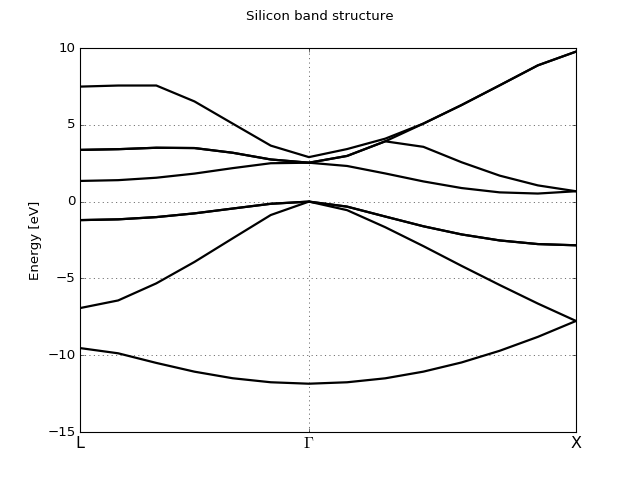

In [4]:
# Open the GSR file produced by a NSCF calculation done with a high-symmetry k-path.
# and extract the electronic band structure.
with abiopen(abidata.ref_file("si_nscf_GSR.nc")) as nscf_file:
    nscf_ebands = nscf_file.ebands

# Plot the band energies. Note that the labels for the k-points are found in an internal database.
fig = nscf_ebands.plot(title="Silicon band structure")

In [5]:
print(nscf_ebands.structure)

Full Formula (Si2)
Reduced Formula: Si
abc   :   3.866975   3.866975   3.866975
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c
---  ----  ----  ----  ----
  0  Si    0     0     0
  1  Si    0.25  0.25  0.25


Alternatively you can use the optional argument `klabels` to define the mapping `reduced_coordinates --> name of the k-point` and pass it to the plot method

<IPython.core.display.Javascript object>


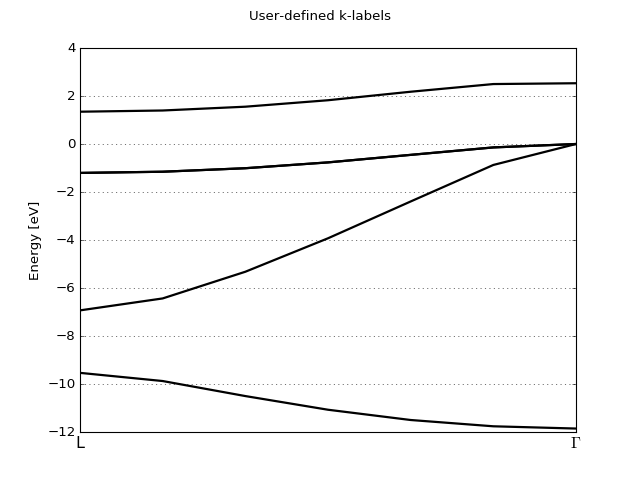

In [6]:
klabels = {
    (0.5, 0.0, 0.0): "L",
    (0.0, 0.0, 0.0): "$\Gamma$",
    (0.0, 0.5, 0.5): "X"
}

figure = nscf_ebands.plot(title="User-defined k-labels", band_range=(0, 5), klabels=klabels)

 <div class="alert alert-success">
The same piece of code works if you replace the `GSR` file with the `WFK` file in netcdf format. 
The main advantage of the `GSR` file is that it is lightweight as it does not store the wavefunctions.
</div>

Let's have a look at our k-points by calling `kpoints.plot()`

<IPython.core.display.Javascript object>


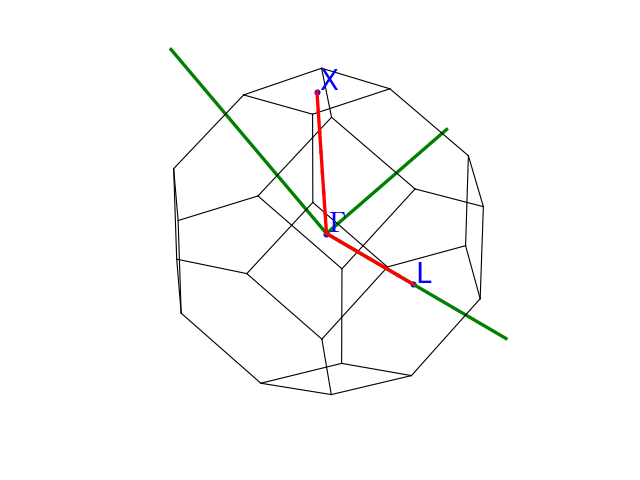

In [7]:
fig = nscf_ebands.kpoints.plot()

## DOS with the gaussian technique

In [14]:
# Open the file and extract the band structure.
with abiopen(abidata.ref_file("si_scf_GSR.nc")) as gs_file:
    gs_ebands = gs_file.ebands

# Compute the DOS with the Gaussian method.
widths = [0.1, 0.2, 0.3, 0.4]
plotter = abilab.ElectronDosPlotter()

for width in widths:
   edos = gs_ebands.get_edos(method="gaussian", step=0.1, width=width)
   label="$\sigma = %s$ [eV]" % width
   plotter.add_edos(label, edos)

<IPython.core.display.Javascript object>


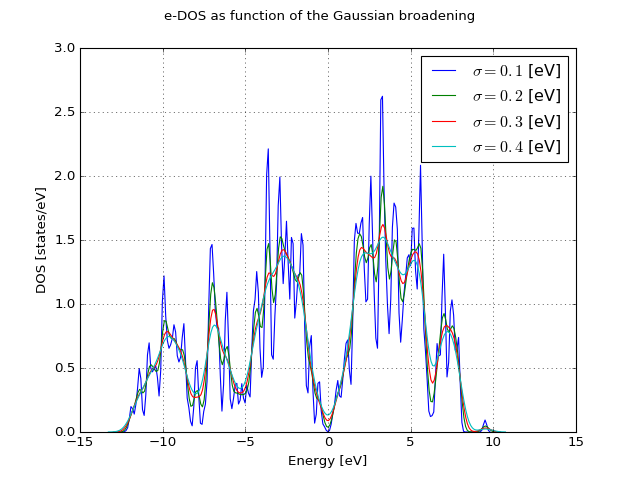

In [16]:
fig = plotter.combiplot(title="e-DOS as function of the Gaussian broadening")

<div class="alert alert-success">
The DOS requires a homogeneous $k$-sampling of the BZ
</div>

### Plotting the band structure and the DOS on the same figure

<IPython.core.display.Javascript object>


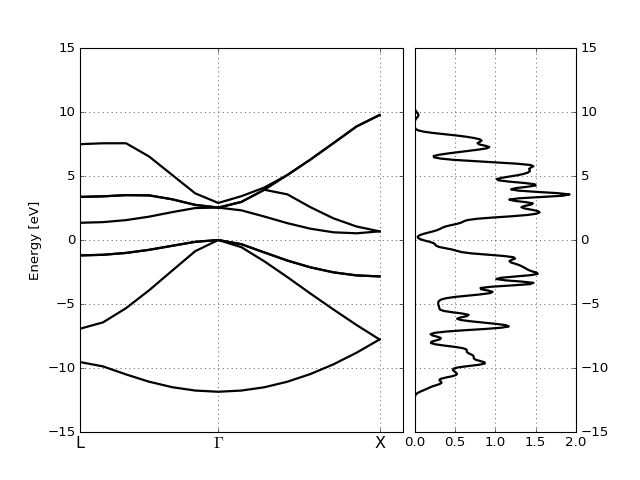

In [13]:
# Compute the DOS with the Gaussian method 
# (use default values for the broadening and the step of the linear mesh).
edos = gs_ebands.get_edos()

# Plot bands and DOS.
figure = nscf_ebands.plot_with_edos(edos)
figure

## Joint density of states (JDOS)

This example shows how plot the different contributions to the electronic joint density of states of Silicon.
Select the valence and conduction bands to include in the JDOS. Here we include valence bands from 0 to 3 and the first conduction band (4).

<IPython.core.display.Javascript object>


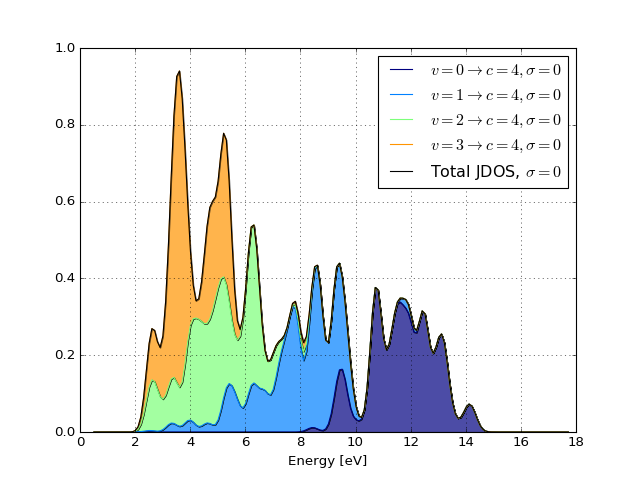

In [17]:
vrange = range(0,4)
crange = range(4,5)

# Plot data
figure = gs_ebands.plot_ejdosvc(vrange, crange)